## Introduction

Here, we will be attemting to build an intermediate Product Recommendation Engine for Amazon Instant Video products targeted for sellers looking to sell the AIV products based on user ratings and past sales.

We will be looking to build the same based on the combined factor of the `product ratings`, given on the AIV products by the users, with the past `sales figures` of the products (giving a weightage of 60% & 40% to the respective features).

## Data

These dataset is a subset of the original [Amazon Product Data](https://jmcauley.ucsd.edu/data/amazon/) dataset, which includes no metadata or reviews, but only (User, Asin, Rating, Timestamp) tuples.\
This dataset also does not include the `sales` feature, which we will utilize here in modelling; rather, we will generate the same figures randomly for each Asin(item_id).

For more information on the dataset or for the complete `Amazon Product Data` dataset or similar, please visit: https://jmcauley.ucsd.edu/data/amazon/

**Data Dictionary:**
 - ***User:*** Unique user id who have rated a particular Asin/Product/Item.
 - ***Asin:*** Unique item id or product id which have been rated by a particular user.
 - ***Rating:*** Unique rating given to that product (1: Lowest and 5: Highest).
 - ***Timestamp:*** Unix epoch timestamp of when a particular user has rated that product.

### 1. Import mandatory modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

### 2. Load and check the data

In [2]:
prod_data = pd.read_csv('./ratings_Amazon_Instant_Video.csv', sep = ',', 
                        names = ['User_id', 'Asin_id', 'Rating', 'Timestamp'])
prod_data.head()

,User_id,Asin_id,Rating,Timestamp
0,A1EE2E3N7PW666,B000GFDAUG,5.0,1202256000
1,AGZ8SM1BGK3CK,B000GFDAUG,5.0,1198195200
2,A2VHZ21245KBT7,B000GIOPK2,4.0,1215388800
3,ACX8YW2D5EGP6,B000GIOPK2,4.0,1185840000
4,A9RNMO9MUSMTJ,B000GIOPK2,2.0,1281052800


### 3. EDA and Data Wrangling

One thing for certain is that we are going to create a Product Recommender system, so for certain, we will not require the `Timestamp` attribute. Lets drop it!

In [3]:
prod_data.drop(['Timestamp'], axis = 1, inplace = True)
prod_data.head(10)

,User_id,Asin_id,Rating
0,A1EE2E3N7PW666,B000GFDAUG,5.0
1,AGZ8SM1BGK3CK,B000GFDAUG,5.0
2,A2VHZ21245KBT7,B000GIOPK2,4.0
3,ACX8YW2D5EGP6,B000GIOPK2,4.0
4,A9RNMO9MUSMTJ,B000GIOPK2,2.0
5,A3STFVPM8NHJ7B,B000GIOPK2,5.0
6,A2582KMXLK2P06,B000GIOPK2,5.0
7,A1TZCLCW9QGGBH,B000GIOPK2,4.0
8,A2E2I6B878CRMA,B000GIOPK2,5.0
9,AD5MZA8SOVMPJ,B000GIOPK2,5.0


Now lets explore the data:

In [4]:
prod_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583933 entries, 0 to 583932
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User_id  583933 non-null  object 
 1   Asin_id  583933 non-null  object 
 2   Rating   583933 non-null  float64
dtypes: float64(1), object(2)
memory usage: 13.4+ MB


Looking at the above info, we can see there are no 'Null' values. So nothing to drop!

Now as explained earlier, we will also be using a `Sales` attribute along with the `Rating` attribute to produce the recommendations. Since we do not have the `Sales` metadata for this subset of products, we will generate random sales figures particular to an Asin_id and store it in a new column.

In [5]:
np.random.seed(123)           ##Set the Random seed for reproducibility

prod_data.set_index('Asin_id', inplace = True)
uniq_idx = prod_data.index.unique()
rand_sales = pd.Series(np.random.uniform(80000, 210000, size = len(uniq_idx)), index = uniq_idx)
prod_data['Sales'] = rand_sales

prod_data = pd.DataFrame(prod_data.reset_index())

prod_data

,Asin_id,User_id,Rating,Sales
0,B000GFDAUG,A1EE2E3N7PW666,5.0,170540.994128
1,B000GFDAUG,AGZ8SM1BGK3CK,5.0,170540.994128
2,B000GIOPK2,A2VHZ21245KBT7,4.0,117198.113544
3,B000GIOPK2,ACX8YW2D5EGP6,4.0,117198.113544
4,B000GIOPK2,A9RNMO9MUSMTJ,2.0,117198.113544
...,...,...,...,...
583928,B00LTMHUW4,A9MBSKL8LTFN9,5.0,154022.815686
583929,B00LTMJ29S,A3U3RFL0XE4F7V,4.0,192721.420383
583930,B00LU8ONBI,AEO407GROR6JB,1.0,112004.471640
583931,B00LU8ONBI,A2YXWWVABHWIXN,5.0,112004.471640


Since we created `Sales` attribute through a uniform distribution, the values are `float64`, lets convert them to `int64`

In [6]:
prod_data['Sales'] = prod_data['Sales'].apply(lambda x: int(x))
prod_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583933 entries, 0 to 583932
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Asin_id  583933 non-null  object 
 1   User_id  583933 non-null  object 
 2   Rating   583933 non-null  float64
 3   Sales    583933 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 17.8+ MB


In [7]:
prod_data

,Asin_id,User_id,Rating,Sales
0,B000GFDAUG,A1EE2E3N7PW666,5.0,170540
1,B000GFDAUG,AGZ8SM1BGK3CK,5.0,170540
2,B000GIOPK2,A2VHZ21245KBT7,4.0,117198
3,B000GIOPK2,ACX8YW2D5EGP6,4.0,117198
4,B000GIOPK2,A9RNMO9MUSMTJ,2.0,117198
...,...,...,...,...
583928,B00LTMHUW4,A9MBSKL8LTFN9,5.0,154022
583929,B00LTMJ29S,A3U3RFL0XE4F7V,4.0,192721
583930,B00LU8ONBI,AEO407GROR6JB,1.0,112004
583931,B00LU8ONBI,A2YXWWVABHWIXN,5.0,112004


Lets check the distribution of the `Sales` column

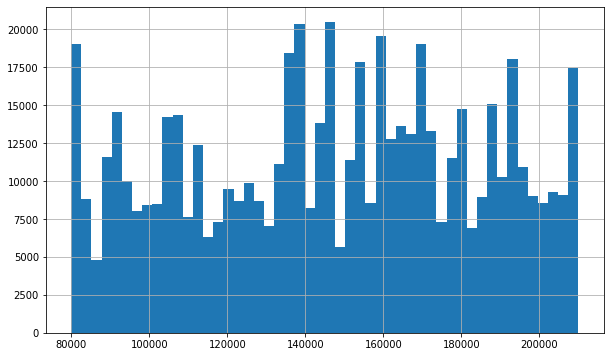

In [8]:
prod_data['Sales'].hist(bins = 50, figsize = (10, 6))

So, as we can see above, even though the `Sales` figures are randomly generated, they approximately follow a Gaussian/Uniform distribution. 

Now as seen that the Asin count is much less than the User count, sufficeth to say that there might be a lot of users who have just rated a single Asin altogether; so to decrease the size of the dataset, lets filter out the rows with Users who have rated less than 3 asins. 

In [9]:
print(sum(prod_data.groupby('User_id').aggregate('count')['Asin_id'] >= 3)) 
print(prod_data.groupby('User_id').aggregate('count')['Asin_id'] >= 3)

29756
User_id
A00019103H5DUGXXX2UPR    False
A00026003EPLG5C4D6XFL    False
A00028442OH78WL2CMSVT    False
A00032403IMUSNRLR3XK7    False
A00039704LRQG87MSTUJ     False
                         ...  
AZZYKX2KZ0Q82            False
AZZYN72HX9NHS            False
AZZYUA6JI1MO0            False
AZZYW4YOE1B6E            False
AZZZEU6VXDYKX            False
Name: Asin_id, Length: 426922, dtype: bool


In [10]:
review_count_df = prod_data.groupby(by = 'User_id')['Asin_id'].count().reset_index().rename(columns = {'Asin_id': 'Asin_count'})
review_count_df.head(10)

,User_id,Asin_count
0,A00019103H5DUGXXX2UPR,1
1,A00026003EPLG5C4D6XFL,1
2,A00028442OH78WL2CMSVT,1
3,A00032403IMUSNRLR3XK7,1
4,A00039704LRQG87MSTUJ,1
5,A00047861M0C8SCSTKARF,1
6,A00085162GMCAJ3DQHUMY,1
7,A0009988MRFQ3TROTQPI,3
8,A0011380142K64VSX5CAH,1
9,A00123582CZP0R9XC3O0F,1


In [11]:
review_count_df.shape, prod_data['User_id'].unique().shape

((426922, 2), (426922,))

In [12]:
counted_prod_data = prod_data.merge(review_count_df, left_on = 'User_id', right_on = 'User_id', how = 'left')

counted_prod_data.head(10)

,Asin_id,User_id,Rating,Sales,Asin_count
0,B000GFDAUG,A1EE2E3N7PW666,5.0,170540,1
1,B000GFDAUG,AGZ8SM1BGK3CK,5.0,170540,5
2,B000GIOPK2,A2VHZ21245KBT7,4.0,117198,4
3,B000GIOPK2,ACX8YW2D5EGP6,4.0,117198,1
4,B000GIOPK2,A9RNMO9MUSMTJ,2.0,117198,15
5,B000GIOPK2,A3STFVPM8NHJ7B,5.0,117198,6
6,B000GIOPK2,A2582KMXLK2P06,5.0,117198,28
7,B000GIOPK2,A1TZCLCW9QGGBH,4.0,117198,1
8,B000GIOPK2,A2E2I6B878CRMA,5.0,117198,1
9,B000GIOPK2,AD5MZA8SOVMPJ,5.0,117198,1


In [13]:
counted_prod_data = counted_prod_data[counted_prod_data['Asin_count'] >= 3]
counted_prod_data.shape

(135185, 5)

In [14]:
counted_prod_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135185 entries, 1 to 583932
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Asin_id     135185 non-null  object 
 1   User_id     135185 non-null  object 
 2   Rating      135185 non-null  float64
 3   Sales       135185 non-null  int64  
 4   Asin_count  135185 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.2+ MB


Now that the rows are filtered, lets create a new column which would contain the weighted sum of the 'Ratings' and 'Sales' columns.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

counted_prod_data['sc_Rating'] = scaler.fit_transform(counted_prod_data.drop(['Asin_id', 'User_id', 'Sales', 'Asin_count'], 
                                                                             axis = 1))
counted_prod_data['sc_Sales'] = scaler.fit_transform(counted_prod_data.drop(['Asin_id', 'User_id', 'Rating', 'Asin_count', 'sc_Rating'], 
                                                                             axis = 1))

counted_prod_data.head(10)

,Asin_id,User_id,Rating,Sales,Asin_count,sc_Rating,sc_Sales
1,B000GFDAUG,AGZ8SM1BGK3CK,5.0,170540,5,1.00,0.696523
2,B000GIOPK2,A2VHZ21245KBT7,4.0,117198,4,0.75,0.286128
4,B000GIOPK2,A9RNMO9MUSMTJ,2.0,117198,15,0.25,0.286128
5,B000GIOPK2,A3STFVPM8NHJ7B,5.0,117198,6,1.00,0.286128
6,B000GIOPK2,A2582KMXLK2P06,5.0,117198,28,1.00,0.286128
12,B000GIOPK2,A2XNOB1T796Y6B,5.0,117198,9,1.00,0.286128
15,B000GIOPK2,AVYBQU4XX5QR4,4.0,117198,3,0.75,0.286128
17,B000GIOPK2,A27AWN5G5GT6RP,5.0,117198,3,1.00,0.286128
22,B000GIOPK2,A2K72PJNBUP2TI,5.0,117198,3,1.00,0.286128
27,B000GIOPK2,AJKWF4W7QD4NS,3.0,117198,26,0.50,0.286128


In [16]:
counted_prod_data['sales_rating'] = 0.6 * counted_prod_data['sc_Rating'] + 0.4 * counted_prod_data['sc_Sales']
counted_prod_data.head(10)

,Asin_id,User_id,Rating,Sales,Asin_count,sc_Rating,sc_Sales,sales_rating
1,B000GFDAUG,AGZ8SM1BGK3CK,5.0,170540,5,1.00,0.696523,0.878609
2,B000GIOPK2,A2VHZ21245KBT7,4.0,117198,4,0.75,0.286128,0.564451
4,B000GIOPK2,A9RNMO9MUSMTJ,2.0,117198,15,0.25,0.286128,0.264451
5,B000GIOPK2,A3STFVPM8NHJ7B,5.0,117198,6,1.00,0.286128,0.714451
6,B000GIOPK2,A2582KMXLK2P06,5.0,117198,28,1.00,0.286128,0.714451
12,B000GIOPK2,A2XNOB1T796Y6B,5.0,117198,9,1.00,0.286128,0.714451
15,B000GIOPK2,AVYBQU4XX5QR4,4.0,117198,3,0.75,0.286128,0.564451
17,B000GIOPK2,A27AWN5G5GT6RP,5.0,117198,3,1.00,0.286128,0.714451
22,B000GIOPK2,A2K72PJNBUP2TI,5.0,117198,3,1.00,0.286128,0.714451
27,B000GIOPK2,AJKWF4W7QD4NS,3.0,117198,26,0.50,0.286128,0.414451


Now that we have filtered and created the weighted column, lets drop the unimportant columns

In [17]:
counted_prod_data.drop(['Asin_count', 'sc_Rating', 'sc_Sales'], axis = 1, inplace = True)
counted_prod_data.head(10)

,Asin_id,User_id,Rating,Sales,sales_rating
1,B000GFDAUG,AGZ8SM1BGK3CK,5.0,170540,0.878609
2,B000GIOPK2,A2VHZ21245KBT7,4.0,117198,0.564451
4,B000GIOPK2,A9RNMO9MUSMTJ,2.0,117198,0.264451
5,B000GIOPK2,A3STFVPM8NHJ7B,5.0,117198,0.714451
6,B000GIOPK2,A2582KMXLK2P06,5.0,117198,0.714451
12,B000GIOPK2,A2XNOB1T796Y6B,5.0,117198,0.714451
15,B000GIOPK2,AVYBQU4XX5QR4,4.0,117198,0.564451
17,B000GIOPK2,A27AWN5G5GT6RP,5.0,117198,0.714451
22,B000GIOPK2,A2K72PJNBUP2TI,5.0,117198,0.714451
27,B000GIOPK2,AJKWF4W7QD4NS,3.0,117198,0.414451


Now lets create a pivot with 'User_id' as rows, 'Asin_id' as column and 'sales_rating' as values

In [18]:
prod_data_pivot = counted_prod_data.pivot_table(index = 'User_id', columns = 'Asin_id', values = 'sales_rating').fillna(0.0)

prod_data_pivot.head(20)

Asin_id,B000GFDAUG,B000GIOPK2,B000GIPKWY,B000GK6NFK,B000GOTJGG,B000GOW7RE,B000GOW9B8,B000GOYLNC,B000GQ02C4,B000GQQ60Q,...,B00LM2SLW4,B00LM493J2,B00LM4TNMY,B00LM4VLM4,B00LP9D10Q,B00LPWPMCS,B00LSWLQQQ,B00LTMJ29S,B00LU8ONBI,B00LXQXLGU
User_id,,,,,,,,,,,,,,,,,,,,,
A0009988MRFQ3TROTQPI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00273743PH7ROD2TRHFE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0075853173YJ1MXA0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00810132N2SJJVSNT18B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0125709MZ35QG7BUG36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01604302QUMH6I622L0V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01782983RWA4QL6FKEZE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02161152MOG2ZERK43S5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A024062949D8UXFDOW6T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
prod_data_pivot.shape

(29756, 15149)

### 4. Build the Models

Now that the pivot table is created, we can start with our Recommendation modelling

1st we will use `TruncatedSVD` with 20 components and filter the top 10 item based(in this case Asin based) recommendations based on `cosine_similarity`. 

***Note:*** We can also create User based recommendations, just that we will have to use the `User_id` to create the `Latent Factors` using TruncatedSVD. 

In [20]:
from sklearn.decomposition import TruncatedSVD

# Set initial hyperparameters
epsilon = 1e-9
n_latent_factors = 20

item_svd = TruncatedSVD(n_components = n_latent_factors)
item_features = item_svd.fit_transform(prod_data_pivot.transpose()) + epsilon

item_features

array([[ 1.09117712e-04,  1.25267480e-04, -1.12303334e-05, ...,
         3.61087857e-04, -3.58920534e-04, -3.66585081e-04],
       [ 1.30331883e-03,  1.55466507e-03, -1.25350186e-05, ...,
         8.78188834e-03,  1.31108991e-03,  2.53564134e-03],
       [ 6.34310769e-04,  8.42828734e-04, -1.01861847e-04, ...,
         3.35499974e-03, -9.90922429e-05,  1.06075909e-03],
       ...,
       [ 5.38744321e-04,  8.17008655e-04, -1.78831964e-04, ...,
         4.46602809e-03, -8.23383404e-03, -7.15002025e-03],
       [ 4.39136989e-06,  6.90944901e-07, -2.88532384e-06, ...,
         1.29263208e-05,  3.07983057e-06, -1.07766918e-05],
       [ 1.49664625e-06,  1.64413875e-06, -5.37303231e-07, ...,
         3.64069285e-05,  1.71452338e-05, -1.31344796e-05]])

As seen above, item_features produces an array of items x latent_features matrix with each row corresponding to a single unique Asin_id (based on the weighted sum of its ratings and sales).

We will now generate the top 10 Asin recommendations against a given Asin based on `Cosine-Similarity`.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matx = cosine_similarity(item_features)

item_ind = {}
for asin, ind in enumerate(np.array(prod_data_pivot.columns)):
    item_ind.update({ind: asin})

# Finding the top 10 similar asins to an Asin taken beforehand
asin_to_compare = np.random.choice(prod_data_pivot.columns)

top_items = sim_matx[item_ind.get(asin_to_compare), :].argsort()[-11:][::-1]
top_10_items = prod_data_pivot.columns[top_items]

print('The top 10 recommended items against the selected asin: ', asin_to_compare)
final_data = counted_prod_data[counted_prod_data['Asin_id'].isin(top_10_items)]
final_data.groupby('Asin_id').aggregate('mean').drop(asin_to_compare, axis = 0)

The top 10 recommended items against the selected asin:  B001RBZL7I


,Rating,Sales,sales_rating
Asin_id,,,
B000I5O6Y8,4.333333,90317.0,0.531726
B001R1M1IK,4.666667,176874.0,0.848102
B0029L1KDE,4.500000,142012.0,0.715815
B003A3R1VU,5.000000,87372.0,0.622662
B004EE472A,2.000000,132721.0,0.312223
B00516Y5FY,4.000000,150683.0,0.667500
B0082CXI34,4.857143,159649.0,0.823664
B0087J3JOA,5.000000,109091.0,0.689502
B0095DFVDO,2.000000,182541.0,0.465542


As seen above, those are the list of recommendations based on our SVD technique.

We will now use the `NearestNeighbors` algorithm with the `cosine_similarity` as metric to produce our recommendations against the same given asin and will compare the results.

In [22]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

prod_data_sparse = csr_matrix(prod_data_pivot.transpose().values)

model_nn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_nn.fit(prod_data_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

Select the record for the given asin above from the `prod_data_pivot` table.

In [23]:
query_data = prod_data_pivot.transpose().loc[asin_to_compare].values.reshape(1, -1)
query_data

array([[0., 0., 0., ..., 0., 0., 0.]])

In [24]:
distances, indices = model_nn.kneighbors(query_data, n_neighbors = 11)

distances, indices

(array([[0.        , 0.        , 0.42264973, 0.63313156, 0.83251182,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        ]]),
 array([[ 4524,  1495, 10149,    17,  3934, 10098, 10093, 10101, 10100,
         10095, 10099]]))

In [25]:
asin_list = prod_data_pivot.columns[indices.flatten()]

print('The top 10 recommended items against the selected asin: ', asin_to_compare)
final_data = counted_prod_data[counted_prod_data['Asin_id'].isin(asin_list)]
final_data.groupby('Asin_id').aggregate('mean').drop(asin_to_compare, axis = 0)

The top 10 recommended items against the selected asin:  B001RBZL7I


,Rating,Sales,sales_rating
Asin_id,,,
B000H244DK,4.500000,192620.0,0.871560
B003YD07X0,3.000000,119909.0,0.422794
B004EE472A,2.000000,132721.0,0.312223
B00AYEO6NE,4.000000,86941.0,0.471336
B00AYKRU1S,3.600000,155893.0,0.623534
B00AYPW16C,4.000000,103812.0,0.523256
B00AYRIFH4,4.684211,111567.0,0.649753
B00AYT159C,4.727273,195151.0,0.913440
B00AYTIG1C,4.666667,184538.0,0.871688


So, as we can see above, `NearestNeighbors` produces some very different recommendations than that of the SVD technique, only common asin recommended in both being `B004EE472A`.

Though `NearestNeighbors` is a pretty robust algorithm,each of the techniques have their own pros and cons; ad being a recommendation algorithm, there is no correct approach. Therefore, we can conclude that both our techniques work differently when produced with the same data.